In [209]:
# importing libraries 
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date,timedelta
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

import seaborn as sns
sns.set(style = 'ticks')

# What promotional offer to give to a particular customer in a given time ?


# When to give a promotional offer to a particular customer and for what value?

In [2]:
#reading the data from the excel file
customer_ds = pd.read_excel('C:/Users/Jewin/Desktop/Jovita-DataSciene/DATA/Capstone/Online Retail.xlsx')

In [3]:
customer_ds

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [4]:
#Considering only customer's from UK , else payment value would differ
customer_ds=customer_ds[customer_ds['Country']=='United Kingdom']


In [5]:
#deleting the columns not required for analysis
customer_ds=customer_ds.drop(columns=['StockCode','Description','Country'])

In [6]:
#quering the null values
print(customer_ds.isnull().sum())

InvoiceNo           0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
dtype: int64


In [7]:
#deleting the rows with customer id as null
customer_ds=customer_ds[~customer_ds['CustomerID'].isnull()]

In [8]:
#Checking the data types
customer_ds.dtypes

InvoiceNo              object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
dtype: object

In [9]:
#Adding an columns to get the payment value (quantity*unit price)
customer_ds['payment_value']=customer_ds['Quantity']*customer_ds['UnitPrice']

In [10]:
customer_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,361878.0,11.077029,263.129266,-80995.0,2.00,4.00,12.00,80995.0
UnitPrice,361878.0,3.256007,70.654731,0.0,1.25,1.95,3.75,38970.0
CustomerID,361878.0,15547.871368,1594.402590,12346.0,14194.00,15514.00,16931.00,18287.0
payment_value,361878.0,18.702086,451.918484,-168469.6,3.75,10.20,17.70,168469.6


In [11]:
#function to calculate recency, frequeny and payment value for each customer
def calculate_RFP(customer_ds):
    #getting the maximum Invoice date in the dataset
    max_date=pd.to_datetime(customer_ds['InvoiceDate'].max(), format=None).to_period('D').to_timestamp()+ timedelta(days=1) 
    #getting the maximum invoice date for each customer (excluding the returned orders) and subtracting from max_date in dataset
    customer=customer_ds[customer_ds["Quantity"] > 0].groupby(["CustomerID"])["InvoiceDate"].max().reset_index()
    #getting the days of customer's recent visit
    customer['Recency']=(max_date-customer['InvoiceDate']).dt.days
    frequency=customer_ds[customer_ds["Quantity"] > 0].groupby(["CustomerID"]).InvoiceNo.nunique().reset_index()
    frequency.columns = ['CustomerID','Frequency']
    customer = pd.merge(customer, frequency, on='CustomerID')
    payment = customer_ds.groupby('CustomerID').payment_value.sum().reset_index()
    payment.columns = ['CustomerID','Payment']
    customer = pd.merge(customer, payment, on='CustomerID')
    return customer

In [12]:
#Function call to calculate recency , frequency and payment value for each customer
customer=calculate_RFP(customer_ds)

In [13]:
customer.head()

,CustomerID,InvoiceDate,Recency,Frequency,Payment
0,12346.0,2011-01-18 10:01:00,325,1,0.00
1,12747.0,2011-12-07 14:34:00,2,11,4196.01
2,12748.0,2011-12-09 12:20:00,0,210,29072.10
3,12749.0,2011-12-06 09:56:00,3,5,3868.20
4,12820.0,2011-12-06 15:12:00,3,4,942.34


In [14]:
customer.describe()

,CustomerID,Recency,Frequency,Payment
count,3921.000000,3921.000000,3921.000000,3921.000000
mean,15561.471563,91.722265,4.246111,1728.365007
std,1576.823683,99.528532,7.205750,6570.071115
min,12346.000000,0.000000,1.000000,-1165.300000
25%,14208.000000,17.000000,1.000000,289.820000
50%,15569.000000,50.000000,2.000000,633.660000
75%,16913.000000,142.000000,5.000000,1530.750000
max,18287.000000,373.000000,210.000000,256438.490000


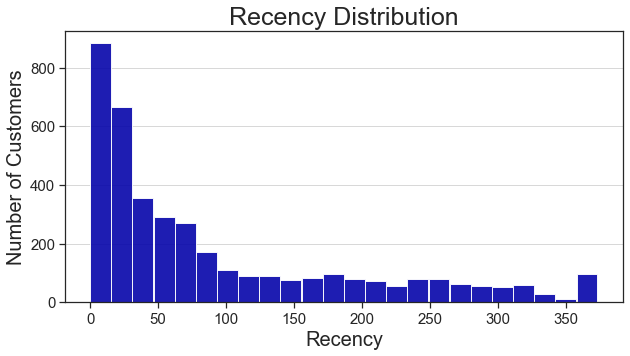

In [15]:
plt.figure(figsize=(10,5))
plt.hist(x=customer['Recency'], bins='auto', color='#0504aa',alpha=0.9, rwidth=0.99)
plt.title('Recency Distribution',fontsize=25)
plt.xlabel('Recency',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)


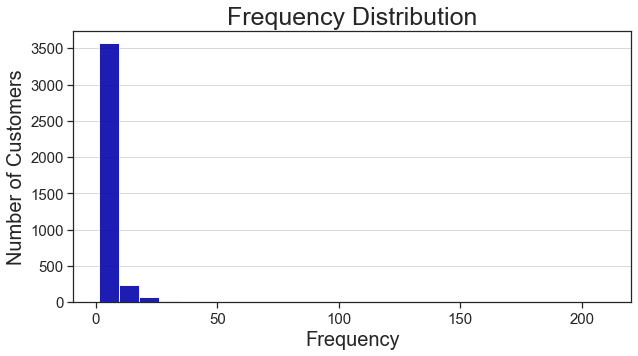

In [16]:
plt.figure(figsize=(10,5))
plt.hist(x=customer['Frequency'], bins=25, color='#0504aa',alpha=0.9, rwidth=0.99)
plt.title('Frequency Distribution',fontsize=25)
plt.xlabel('Frequency',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)


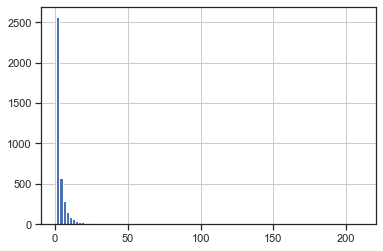

In [17]:
customer['Frequency'].hist(bins=100)

(array([12000., 13000., 14000., 15000., 16000., 17000., 18000., 19000.]),
 <a list of 8 Text yticklabel objects>)

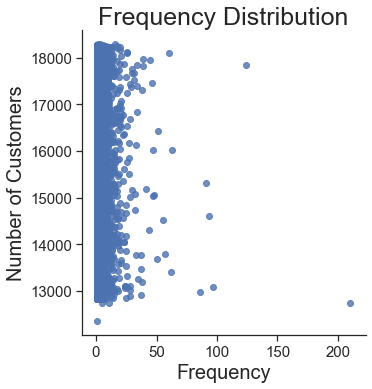

In [18]:
sns.lmplot(x='Frequency', y='CustomerID', data=customer, 
           fit_reg=False)
plt.title('Frequency Distribution',fontsize=25)
plt.xlabel('Frequency',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

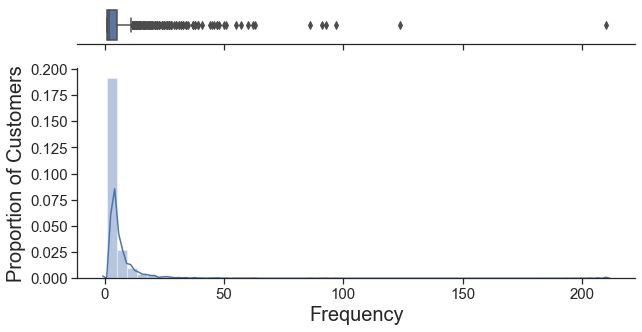

In [19]:
fig, ax = plt.subplots(2, 
                           figsize = (10, 5),
                           sharex = True, 
                           gridspec_kw = {'height_ratios': (0.15, 0.85)})

ax_box = ax[0]
ax_box = sns.boxplot(customer['Frequency'], ax = ax_box)
ax_box.set(title = '', yticks = [], xlabel = '')
sns.despine(ax = ax_box, left = True)

ax_hist = ax[1]
ax_hist = sns.distplot(customer['Frequency'], ax = ax_hist)
ax_hist.set(xlabel = 'Frequency')
sns.despine(ax = ax_hist)

plt.xlabel('Frequency',fontsize=20)
plt.ylabel('Proportion of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

(array([12000., 13000., 14000., 15000., 16000., 17000., 18000., 19000.]),
 <a list of 8 Text yticklabel objects>)

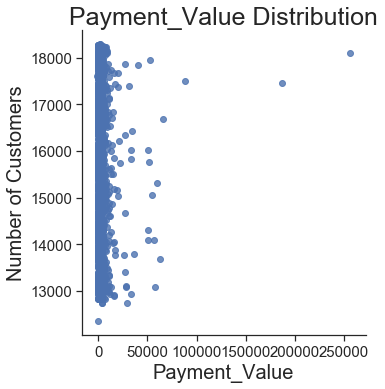

In [20]:
sns.lmplot(x='Payment', y='CustomerID', data=customer, 
           fit_reg=False)
plt.title('Payment_Value Distribution',fontsize=25)
plt.xlabel('Payment_Value',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

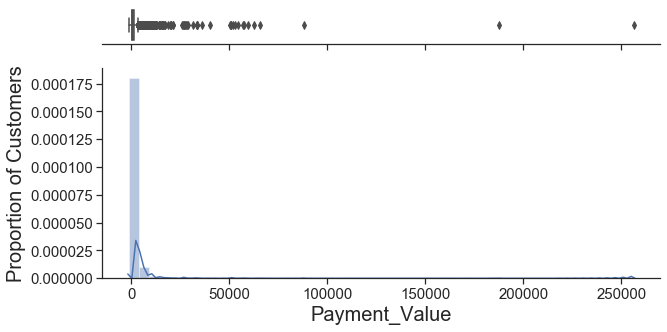

In [21]:
fig, ax = plt.subplots(2, 
                           figsize = (10, 5),
                           sharex = True, 
                           gridspec_kw = {'height_ratios': (0.15, 0.85)})

ax_box = ax[0]
ax_box = sns.boxplot(customer['Payment'], ax = ax_box)
ax_box.set(title = '', yticks = [], xlabel = '')
sns.despine(ax = ax_box, left = True)

ax_hist = ax[1]
ax_hist = sns.distplot(customer['Payment'], ax = ax_hist)
ax_hist.set(xlabel = 'Payment_Value')
sns.despine(ax = ax_hist)

plt.xlabel('Payment_Value',fontsize=20)
plt.ylabel('Proportion of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [22]:
plot_payment=customer[customer['Payment']<10000]

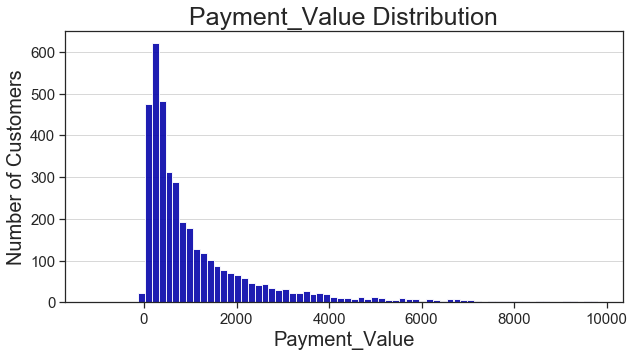

In [23]:
#Plotting the graph for payment value lesser than 10,000 for better visualization 

plt.figure(figsize=(10,5))
plt.hist(x=plot_payment['Payment'], bins='auto', color='#0504aa',alpha=0.9, rwidth=0.99)
plt.title('Payment_Value Distribution',fontsize=25)
plt.xlabel('Payment_Value',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)

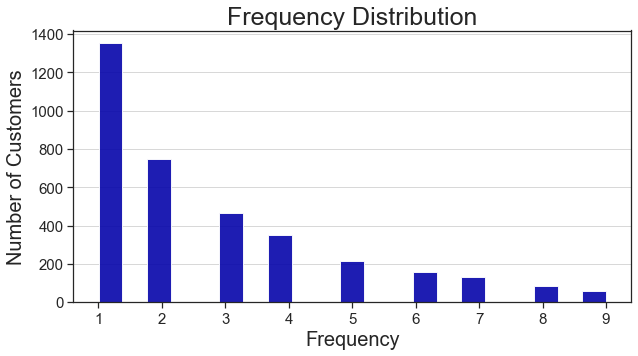

In [24]:
#Plotting the graph for payment value lesser than 10 for better visualization 

plot_frequency=customer[customer['Frequency']<10]
plt.figure(figsize=(10,5))
plt.hist(x=plot_frequency['Frequency'], bins='auto', color='#0504aa',alpha=0.9, rwidth=0.99)
plt.title('Frequency Distribution',fontsize=25)
plt.xlabel('Frequency',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)

In [25]:
customer.corr()

,CustomerID,Recency,Frequency,Payment
CustomerID,1.000000,0.008299,-0.020160,0.007221
Recency,0.008299,1.000000,-0.273779,-0.146529
Frequency,-0.020160,-0.273779,1.000000,0.553537
Payment,0.007221,-0.146529,0.553537,1.000000


(6.0, 0)

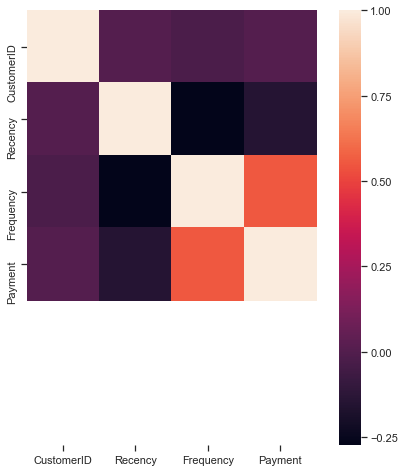

In [26]:
plt.figure(figsize=(8,8))
ax=sns.heatmap(customer.corr(),square = True)
ax.set_ylim(6.0, 0)

(array([-100000.,       0.,  100000.,  200000.,  300000.]),
 <a list of 0 Text xticklabel objects>)

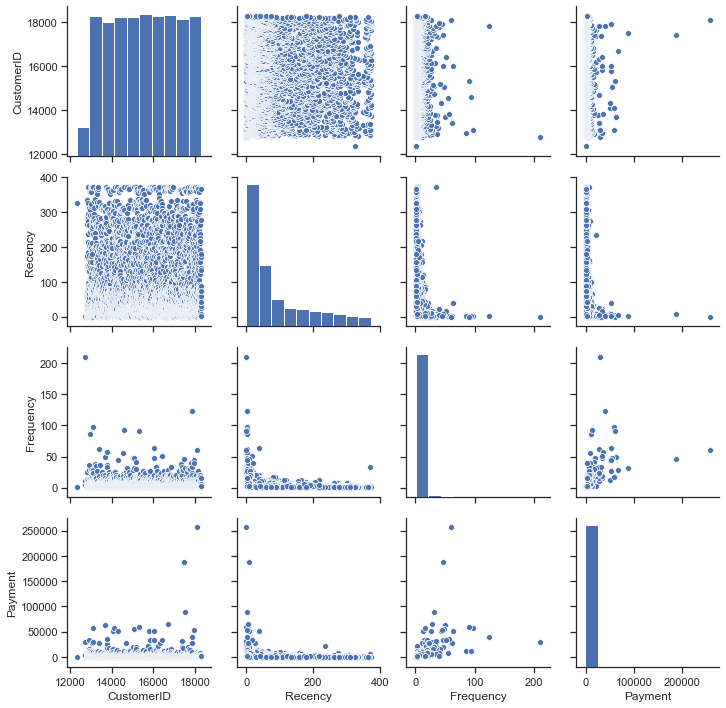

In [27]:
sns.pairplot(customer)
plt.xticks(fontsize=5)

In [28]:
#Coverting the recency from number of days to a ordered ranking number
customer['Recency_RANK']=customer['Recency'].rank(method='max')
customer['PCNT_RANK']=customer['Recency'].rank(method='max', pct=True)
customer['Ordered_Recency_Per']=1-customer['PCNT_RANK']

In [29]:
customer.head()

,CustomerID,InvoiceDate,Recency,Frequency,Payment,Recency_RANK,PCNT_RANK,Ordered_Recency_Per
0,12346.0,2011-01-18 10:01:00,325,1,0.00,3781.0,0.964295,0.035705
1,12747.0,2011-12-07 14:34:00,2,11,4196.01,208.0,0.053048,0.946952
2,12748.0,2011-12-09 12:20:00,0,210,29072.10,28.0,0.007141,0.992859
3,12749.0,2011-12-06 09:56:00,3,5,3868.20,292.0,0.074471,0.925529
4,12820.0,2011-12-06 15:12:00,3,4,942.34,292.0,0.074471,0.925529


In [30]:
#Coverting the frequency and payment value from number of days and currency value to a ordered ranking number
customer['Frequency_RANK']=customer['Frequency'].rank(method='max', pct=True)
customer['Payement_RANK']=customer['Payment'].rank(method='max', pct=True)

In [31]:
#Taking average of the 3 to rank the total for each customer
customer['Total_Rank']=(customer['Frequency_RANK']+customer['Payement_RANK']+customer['Ordered_Recency_Per'])/3

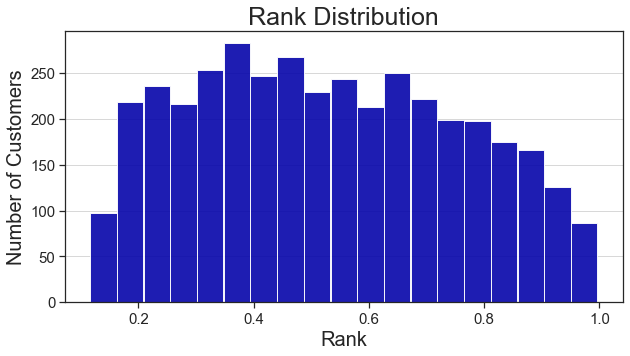

In [32]:
#customer['Total_Rank'].hist(bins=10, figsize=[14,6])
plt.figure(figsize=(10,5))
plt.hist(x=customer['Total_Rank'], bins='auto', color='#0504aa',alpha=0.9, rwidth=0.99)
plt.title('Rank Distribution',fontsize=25)
plt.xlabel('Rank',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)

In [33]:
customer['CLTV']=pd.cut(customer.Total_Rank, bins=4, labels=np.arange(4), right=False)

In [34]:
customer.head()

,CustomerID,InvoiceDate,Recency,Frequency,Payment,Recency_RANK,PCNT_RANK,Ordered_Recency_Per,Frequency_RANK,Payement_RANK,Total_Rank,CLTV
0,12346.0,2011-01-18 10:01:00,325,1,0.00,3781.0,0.964295,0.035705,0.344555,0.004081,0.128114,0
1,12747.0,2011-12-07 14:34:00,2,11,4196.01,208.0,0.053048,0.946952,0.933435,0.930630,0.937006,3
2,12748.0,2011-12-09 12:20:00,0,210,29072.10,28.0,0.007141,0.992859,1.000000,0.994644,0.995834,3
3,12749.0,2011-12-06 09:56:00,3,5,3868.20,292.0,0.074471,0.925529,0.798266,0.922214,0.882003,3
4,12820.0,2011-12-06 15:12:00,3,4,942.34,292.0,0.074471,0.925529,0.742923,0.621270,0.763241,2


In [35]:
df=customer[['CustomerID','Ordered_Recency_Per','Frequency_RANK','Payement_RANK']]
Xs = normalize(df)

In [36]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Xs)
    Sum_of_squared_distances.append(km.inertia_)

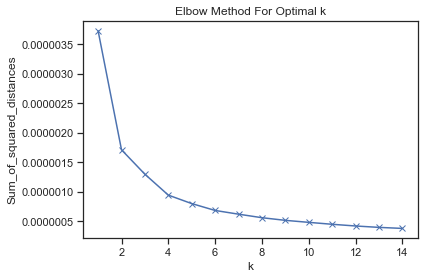

In [37]:
#Code to get the optimal value for k
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [38]:
k = 4
# 4 Clusters
k_mean2 = KMeans(n_clusters=k)
k_mean2.fit(Xs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [39]:
customer['Cluster'] = k_mean2.labels_

In [40]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    #print(df_final)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [41]:
customer=order_cluster('Cluster','Total_Rank',customer,True)

In [42]:
customer

,CustomerID,InvoiceDate,Recency,Frequency,Payment,Recency_RANK,PCNT_RANK,Ordered_Recency_Per,Frequency_RANK,Payement_RANK,Total_Rank,CLTV,Cluster
0,12346.0,2011-01-18 10:01:00,325,1,0.000000e+00,3781.0,0.964295,0.035705,0.344555,0.004081,0.128114,0,0
1,12821.0,2011-05-09 15:51:00,214,1,9.272000e+01,3322.0,0.847233,0.152767,0.344555,0.037235,0.178186,0,0
2,12829.0,2011-01-07 11:13:00,336,2,2.530500e+02,3810.0,0.971691,0.028309,0.534813,0.220097,0.261073,0,0
3,12831.0,2011-03-22 13:02:00,262,1,2.150500e+02,3539.0,0.902576,0.097424,0.344555,0.180311,0.207430,0,0
4,12833.0,2011-07-17 13:46:00,145,1,4.173800e+02,2957.0,0.754144,0.245856,0.344555,0.378475,0.322962,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3916,18270.0,2011-11-01 13:57:00,38,2,2.389500e+02,1724.0,0.439684,0.560316,0.534813,0.203775,0.432968,1,1
3917,18273.0,2011-12-07 13:16:00,2,3,2.040000e+02,208.0,0.053048,0.946952,0.653405,0.167304,0.589220,2,1
3918,18274.0,2011-11-09 17:03:00,30,1,1.243450e-14,1503.0,0.383321,0.616679,0.344555,0.004336,0.321857,0,1
3919,18276.0,2011-10-27 10:54:00,43,1,3.233600e+02,1826.0,0.465698,0.534302,0.344555,0.293037,0.390632,1,1


In [43]:
customer['Cluster'].value_counts()

0    1136
3    1042
2     943
1     800
Name: Cluster, dtype: int64

In [44]:
customer['CLTV'].value_counts()

1    1224
2    1040
0     956
3     701
Name: CLTV, dtype: int64

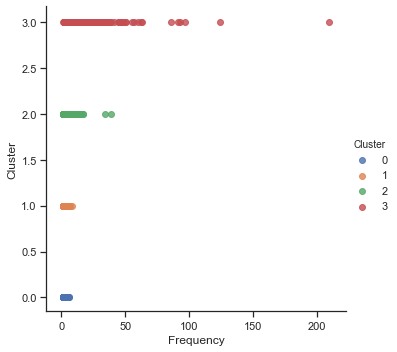

In [45]:
sns.lmplot(x='Frequency', y='Cluster', data=customer, hue='Cluster', 
           fit_reg=False)

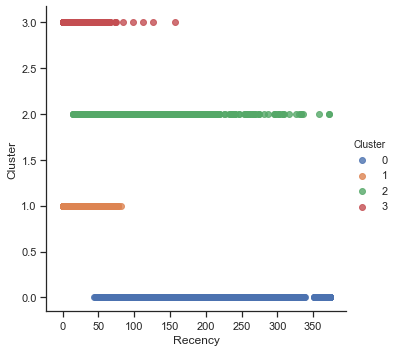

In [46]:
sns.lmplot(x='Recency', y='Cluster', data=customer, hue='Cluster', 
           fit_reg=False)

In [47]:
plot_frequency=customer[customer['Payment']<5000]

<Figure size 1440x720 with 0 Axes>

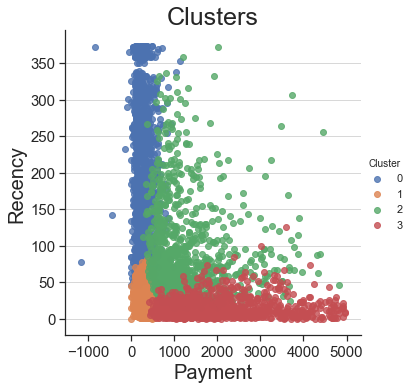

In [48]:
plt.figure(figsize=(20,10))
sns.lmplot(x='Payment', y='Recency', data=plot_frequency, hue='Cluster', fit_reg=False)
plt.title('Clusters',fontsize=25)
plt.xlabel('Payment',fontsize=20)
plt.ylabel('Recency',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)

In [49]:
filter1=customer['Recency']<200
filter2=customer['Frequency']<40
plot_frequency=customer[filter1 & filter2]
#plot_frequency=customer
#plot_frequency=customer[customer['Frequency']<30]

<Figure size 2160x1440 with 0 Axes>

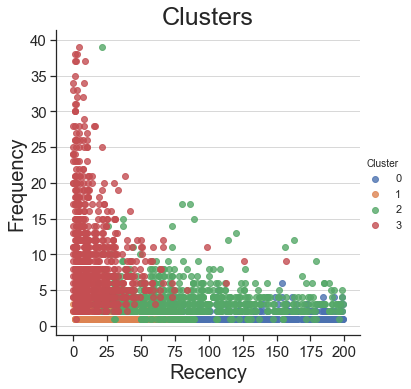

In [50]:
plt.figure(figsize=(30,20))
sns.lmplot(x='Recency', y='Frequency', data=plot_frequency, hue='Cluster', fit_reg=False)
plt.title('Clusters',fontsize=25)
plt.xlabel('Recency',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)
#plt.legend(loc='center right', labels=['Hell Yeh', 'Nah Bruh'])
plt.show()

In [51]:
cust_display=customer
cust_display=cust_display.drop(columns=['CustomerID','InvoiceDate','Recency_RANK','PCNT_RANK','Ordered_Recency_Per','Frequency_RANK','Payement_RANK','Total_Rank','CLTV'])

(array([-1.,  0.,  1.,  2.,  3.,  4.]), <a list of 0 Text xticklabel objects>)

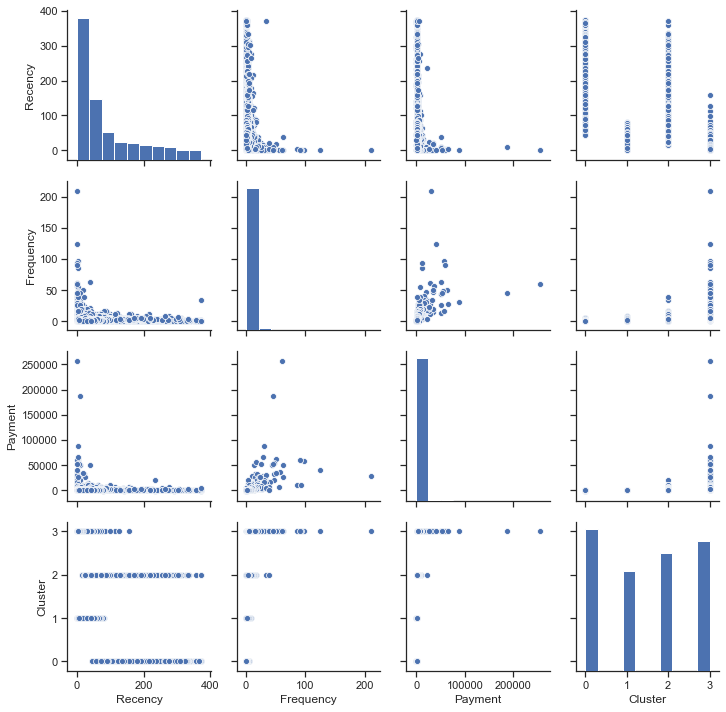

In [52]:
sns.pairplot(cust_display)
plt.xticks(fontsize=5)

In [53]:
Final_clusters=customer

# Predicting next purchase date

In [215]:
Final_end=pd.to_datetime(customer_ds['InvoiceDate'].max(), format=None).to_period('D').to_timestamp()
start_date=pd.to_datetime(customer_ds['InvoiceDate'].min(), format=None).to_period('D').to_timestamp()
split_date=date(2011,8,1)
end_date=date(2011,11,1)

In [216]:
customer_ds

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,payment_value
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,15.30
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
2,536365,8,2010-12-01 08:26:00,2.75,17850.0,22.00
3,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
4,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
...,...,...,...,...,...,...
541889,581585,12,2011-12-09 12:31:00,1.95,15804.0,23.40
541890,581586,8,2011-12-09 12:49:00,2.95,13113.0,23.60
541891,581586,24,2011-12-09 12:49:00,1.25,13113.0,30.00
541892,581586,24,2011-12-09 12:49:00,8.95,13113.0,214.80


In [217]:
training_period=customer_ds.loc[(customer_ds.InvoiceDate >= start_date) & (customer_ds.InvoiceDate <= split_date)]
testing_period=customer_ds.loc[(customer_ds.InvoiceDate > split_date) & (customer_ds.InvoiceDate <= end_date)]

In [218]:
data=pd.DataFrame(training_period['CustomerID'].unique())
data.columns = ['CustomerID']

In [219]:
#first purchase in testing period
testing_period_first_purchase = testing_period[testing_period["Quantity"] > 0].groupby('CustomerID').InvoiceDate.min().reset_index()
#testing_period_first_purchase = testing_period.groupby('CustomerID').InvoiceDate.min().reset_index()
testing_period_first_purchase.columns = ['CustomerID','MinPurchaseDate']

#Last purchase date in training period
training_period_last_purchase = training_period[training_period["Quantity"] > 0].groupby('CustomerID').InvoiceDate.max().reset_index()
#training_period_last_purchase = training_period.groupby('CustomerID').InvoiceDate.max().reset_index()
training_period_last_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [220]:
testing_period_first_purchase

,CustomerID,MinPurchaseDate
0,12747.0,2011-11-17 17:13:00
1,12748.0,2011-11-01 13:49:00
2,12749.0,2011-11-17 12:05:00
3,12820.0,2011-12-06 15:12:00
4,12826.0,2011-11-10 15:37:00
...,...,...
1717,18272.0,2011-12-07 12:43:00
1718,18273.0,2011-12-07 13:16:00
1719,18274.0,2011-11-09 17:03:00
1720,18282.0,2011-12-02 11:43:00


In [221]:
training_period_last_purchase

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:01:00
1,12747.0,2011-10-04 08:26:00
2,12748.0,2011-10-26 13:56:00
3,12749.0,2011-08-01 12:50:00
4,12820.0,2011-10-26 13:27:00
...,...,...
3584,18280.0,2011-03-07 09:52:00
3585,18281.0,2011-06-12 10:53:00
3586,18282.0,2011-08-05 13:35:00
3587,18283.0,2011-10-27 14:38:00


Below dataset gives the last date in training period and first date in testing period

In [222]:
train_test_merge=pd.merge(training_period_last_purchase,testing_period_first_purchase,on='CustomerID',how='left')

In [223]:
train_test_merge

,CustomerID,MaxPurchaseDate,MinPurchaseDate
0,12346.0,2011-01-18 10:01:00,NaT
1,12747.0,2011-10-04 08:26:00,2011-11-17 17:13:00
2,12748.0,2011-10-26 13:56:00,2011-11-01 13:49:00
3,12749.0,2011-08-01 12:50:00,2011-11-17 12:05:00
4,12820.0,2011-10-26 13:27:00,2011-12-06 15:12:00
...,...,...,...
3584,18280.0,2011-03-07 09:52:00,NaT
3585,18281.0,2011-06-12 10:53:00,NaT
3586,18282.0,2011-08-05 13:35:00,2011-12-02 11:43:00
3587,18283.0,2011-10-27 14:38:00,2011-11-10 14:59:00


In [224]:
train_test_merge['NextPurchaseDay_TestPeriod'] = (train_test_merge['MinPurchaseDate'] - train_test_merge['MaxPurchaseDate']).dt.days
data=pd.merge(data, train_test_merge[['CustomerID','NextPurchaseDay_TestPeriod']],on='CustomerID',how='left')

In [225]:
data
#NaN means they do not have a purchase date in that period . 
#for analysis we could consider it as a large next purchase date and fill that number by 999

,CustomerID,NextPurchaseDay_TestPeriod
0,17850.0,NaN
1,13047.0,25.0
2,13748.0,NaN
3,15100.0,NaN
4,15291.0,59.0
...,...,...
3615,13103.0,NaN
3616,15667.0,NaN
3617,13651.0,4.0
3618,16127.0,NaN


In [226]:
data = data.fillna(999)

In [227]:
df_Invoice_Day = training_period[['CustomerID','InvoiceDate']]
df_Invoice_Day['InvoiceDay'] = training_period['InvoiceDate'].dt.date

In [228]:
df_Invoice_Day

,CustomerID,InvoiceDate,InvoiceDay
0,17850.0,2010-12-01 08:26:00,2010-12-01
1,17850.0,2010-12-01 08:26:00,2010-12-01
2,17850.0,2010-12-01 08:26:00,2010-12-01
3,17850.0,2010-12-01 08:26:00,2010-12-01
4,17850.0,2010-12-01 08:26:00,2010-12-01
...,...,...,...
431666,15023.0,2011-10-31 17:13:00,2011-10-31
431667,15023.0,2011-10-31 17:13:00,2011-10-31
431668,15023.0,2011-10-31 17:13:00,2011-10-31
431669,15023.0,2011-10-31 17:13:00,2011-10-31


In [229]:
#drop duplicates
df_Invoice_Day = df_Invoice_Day.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')

In [230]:
#shifting last 3 purchase dates
df_Invoice_Day['n-1'] = df_Invoice_Day.groupby('CustomerID')['InvoiceDay'].shift(1)
df_Invoice_Day['n-2'] = df_Invoice_Day.groupby('CustomerID')['InvoiceDay'].shift(2)
df_Invoice_Day['n-3'] = df_Invoice_Day.groupby('CustomerID')['InvoiceDay'].shift(3)

In [231]:
df_Invoice_Day

,CustomerID,InvoiceDate,InvoiceDay,n-1,n-2,n-3
0,17850.0,2010-12-01 08:26:00,2010-12-01,NaN,NaN,NaN
9,13047.0,2010-12-01 08:34:00,2010-12-01,NaN,NaN,NaN
46,13748.0,2010-12-01 09:00:00,2010-12-01,NaN,NaN,NaN
65,15100.0,2010-12-01 09:09:00,2010-12-01,NaN,NaN,NaN
82,15291.0,2010-12-01 09:32:00,2010-12-01,NaN,NaN,NaN
...,...,...,...,...,...,...
431384,17924.0,2011-10-31 15:20:00,2011-10-31,2011-10-03,2011-02-14,2011-02-11
431515,15329.0,2011-10-31 15:36:00,2011-10-31,2011-07-28,2011-06-21,2010-12-09
431591,13982.0,2011-10-31 16:24:00,2011-10-31,2011-06-29,2011-01-17,2010-12-09
431629,15977.0,2011-10-31 16:24:00,2011-10-31,NaN,NaN,NaN


In [232]:
#getting the difference in days for last purchases in training period
df_Invoice_Day['DayDiff1'] = (df_Invoice_Day['InvoiceDay'] - df_Invoice_Day['n-1']).dt.days
df_Invoice_Day['DayDiff2'] = (df_Invoice_Day['n-1'] - df_Invoice_Day['n-2']).dt.days
df_Invoice_Day['DayDiff3'] = (df_Invoice_Day['n-2'] - df_Invoice_Day['n-3']).dt.days

In [233]:
df_Invoice_Day

,CustomerID,InvoiceDate,InvoiceDay,n-1,n-2,n-3,DayDiff1,DayDiff2,DayDiff3
0,17850.0,2010-12-01 08:26:00,2010-12-01,NaN,NaN,NaN,NaN,NaN,NaN
9,13047.0,2010-12-01 08:34:00,2010-12-01,NaN,NaN,NaN,NaN,NaN,NaN
46,13748.0,2010-12-01 09:00:00,2010-12-01,NaN,NaN,NaN,NaN,NaN,NaN
65,15100.0,2010-12-01 09:09:00,2010-12-01,NaN,NaN,NaN,NaN,NaN,NaN
82,15291.0,2010-12-01 09:32:00,2010-12-01,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
431384,17924.0,2011-10-31 15:20:00,2011-10-31,2011-10-03,2011-02-14,2011-02-11,28.0,231.0,3.0
431515,15329.0,2011-10-31 15:36:00,2011-10-31,2011-07-28,2011-06-21,2010-12-09,95.0,37.0,194.0
431591,13982.0,2011-10-31 16:24:00,2011-10-31,2011-06-29,2011-01-17,2010-12-09,124.0,163.0,39.0
431629,15977.0,2011-10-31 16:24:00,2011-10-31,NaN,NaN,NaN,NaN,NaN,NaN


In [234]:
#retaining only the customers who have 3 or more occurances in training period
day_order_last = df_Invoice_Day.drop_duplicates(subset=['CustomerID'],keep='last')

In [235]:
day_order_last = day_order_last.dropna()

In [236]:
day_order_last

,CustomerID,InvoiceDate,InvoiceDay,n-1,n-2,n-3,DayDiff1,DayDiff2,DayDiff3
56833,15100.0,2011-01-13 17:09:00,2011-01-13,2011-01-10,2010-12-16,2010-12-08,3.0,25.0,8.0
75476,17062.0,2011-01-30 11:01:00,2011-01-30,2010-12-16,2010-12-09,2010-12-05,45.0,7.0,4.0
78905,15107.0,2011-02-01 14:46:00,2011-02-01,2011-01-13,2011-01-11,2011-01-09,19.0,2.0,2.0
80070,17912.0,2011-02-02 14:25:00,2011-02-02,2010-12-15,2010-12-14,2010-12-10,49.0,1.0,4.0
82691,13963.0,2011-02-04 14:43:00,2011-02-04,2011-01-23,2011-01-04,2010-12-07,12.0,19.0,28.0
...,...,...,...,...,...,...,...,...,...
431352,18257.0,2011-10-31 14:48:00,2011-10-31,2011-10-03,2011-08-17,2011-06-24,28.0,47.0,54.0
431384,17924.0,2011-10-31 15:20:00,2011-10-31,2011-10-03,2011-02-14,2011-02-11,28.0,231.0,3.0
431515,15329.0,2011-10-31 15:36:00,2011-10-31,2011-07-28,2011-06-21,2010-12-09,95.0,37.0,194.0
431591,13982.0,2011-10-31 16:24:00,2011-10-31,2011-06-29,2011-01-17,2010-12-09,124.0,163.0,39.0


In [237]:
data = pd.merge(data, day_order_last[['CustomerID','InvoiceDay','DayDiff1','DayDiff2','DayDiff3']], on='CustomerID')

In [238]:
data

,CustomerID,NextPurchaseDay_TestPeriod,InvoiceDay,DayDiff1,DayDiff2,DayDiff3
0,13047.0,25.0,2011-10-24,10.0,57.0,4.0
1,13748.0,999.0,2011-09-05,137.0,14.0,127.0
2,15100.0,999.0,2011-01-13,3.0,25.0,8.0
3,15291.0,59.0,2011-09-06,78.0,8.0,67.0
4,14688.0,32.0,2011-10-31,13.0,18.0,18.0
...,...,...,...,...,...,...
1189,16160.0,999.0,2011-10-06,1.0,13.0,7.0
1190,14356.0,999.0,2011-10-10,13.0,6.0,2.0
1191,14434.0,14.0,2011-10-19,9.0,5.0,7.0
1192,17528.0,12.0,2011-10-27,6.0,9.0,13.0


(array([12., 24., 44., 38., 55., 44., 35., 36., 41., 48., 67., 39., 21.,
        27., 17., 23., 18., 20., 10., 11., 12.,  7.,  5.,  3.,  5., 11.,
         8.,  8.,  2.,  5.,  2.,  5.,  0.,  0.,  4.,  1.,  3.,  1.,  2.,
         1.,  2.,  2.,  3.,  1.,  1.,  4.,  0.,  0.,  2.,  2.]),
 array([  2.  ,   5.88,   9.76,  13.64,  17.52,  21.4 ,  25.28,  29.16,
         33.04,  36.92,  40.8 ,  44.68,  48.56,  52.44,  56.32,  60.2 ,
         64.08,  67.96,  71.84,  75.72,  79.6 ,  83.48,  87.36,  91.24,
         95.12,  99.  , 102.88, 106.76, 110.64, 114.52, 118.4 , 122.28,
        126.16, 130.04, 133.92, 137.8 , 141.68, 145.56, 149.44, 153.32,
        157.2 , 161.08, 164.96, 168.84, 172.72, 176.6 , 180.48, 184.36,
        188.24, 192.12, 196.  ]),
 <a list of 50 Patch objects>)

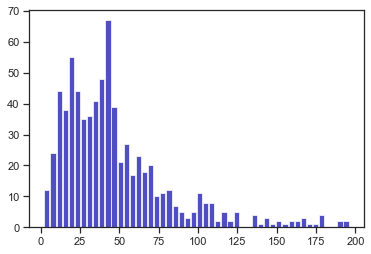

In [239]:
plot_data=data[data['NextPurchaseDay_TestPeriod']<200]
plt.hist(x=plot_data['NextPurchaseDay_TestPeriod'], bins=50, color='#0504aa',
                            alpha=0.7, rwidth=0.85)

In [240]:
test = pd.merge(customer, data[['CustomerID','InvoiceDay','DayDiff1','DayDiff2','DayDiff3','NextPurchaseDay_TestPeriod']], on='CustomerID')

In [241]:
data=test

In [242]:
#Rank the next purchase day
data['NextPurchaseDayRange'] = 0
data.loc[data.NextPurchaseDay_TestPeriod>30,'NextPurchaseDayRange'] = 1
data.loc[data.NextPurchaseDay_TestPeriod>70,'NextPurchaseDayRange'] = 2
data.loc[data.NextPurchaseDay_TestPeriod>150,'NextPurchaseDayRange'] = 3


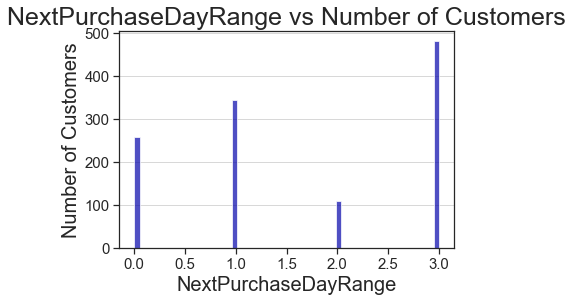

In [243]:
plt.hist(x=data['NextPurchaseDayRange'], bins=50, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.title('NextPurchaseDayRange vs Number of Customers',fontsize=25)
plt.xlabel('NextPurchaseDayRange',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)

In [244]:
data

,CustomerID,InvoiceDate,Recency,Frequency,Payment,Recency_RANK,PCNT_RANK,Ordered_Recency_Per,Frequency_RANK,Payement_RANK,Total_Rank,CLTV,Cluster,InvoiceDay,DayDiff1,DayDiff2,DayDiff3,NextPurchaseDay_TestPeriod,NextPurchaseDayRange
0,12888.0,2011-05-09 16:02:00,214,2,313.77,3322.0,0.847233,0.152767,0.534813,0.282071,0.323217,0,0,2011-05-09,6.0,32.0,3.0,999.0,3
1,13217.0,2011-08-09 15:32:00,122,3,133.62,2830.0,0.721755,0.278245,0.653405,0.083142,0.338264,1,0,2011-08-09,9.0,11.0,14.0,999.0,3
2,13420.0,2011-07-13 08:48:00,149,2,140.35,2976.0,0.758990,0.241010,0.534813,0.092833,0.289552,0,0,2011-07-28,15.0,7.0,14.0,999.0,3
3,15107.0,2011-02-01 14:46:00,311,6,247.66,3735.0,0.952563,0.047437,0.838562,0.212956,0.366318,1,0,2011-02-01,19.0,2.0,2.0,999.0,3
4,15646.0,2011-07-05 09:53:00,157,3,425.14,3024.0,0.771232,0.228768,0.653405,0.383831,0.422001,1,0,2011-07-05,85.0,4.0,126.0,999.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,17526.0,2011-12-05 11:05:00,4,4,706.70,378.0,0.096404,0.903596,0.742923,0.540933,0.729151,2,1,2011-05-19,49.0,37.0,70.0,286.0,3
1190,17888.0,2011-11-18 13:45:00,21,8,525.78,1151.0,0.293548,0.706452,0.893905,0.440959,0.680439,2,1,2011-10-11,20.0,82.0,51.0,21.0,0
1191,17929.0,2011-11-28 16:01:00,11,4,834.50,749.0,0.191023,0.808977,0.742923,0.587605,0.713168,2,1,2011-09-23,35.0,142.0,54.0,101.0,2
1192,18211.0,2011-11-14 08:10:00,25,5,600.07,1345.0,0.343025,0.656975,0.798266,0.479470,0.644904,2,1,2011-10-27,42.0,51.0,142.0,17.0,0


In [246]:
data['NextPurchaseDayRange'].value_counts()

3    481
1    345
0    258
2    110
Name: NextPurchaseDayRange, dtype: int64

In [247]:
data.corr()

,CustomerID,Recency,Frequency,Payment,Recency_RANK,PCNT_RANK,Ordered_Recency_Per,Frequency_RANK,Payement_RANK,Total_Rank,Cluster,DayDiff1,DayDiff2,DayDiff3,NextPurchaseDay_TestPeriod,NextPurchaseDayRange
CustomerID,1.000000,0.040340,-0.033899,0.022677,0.039451,0.039451,-0.039451,0.002464,-0.064621,-0.045681,-0.273167,0.037132,0.032737,-0.003335,0.025234,0.015181
Recency,0.040340,1.000000,-0.278878,-0.156937,0.887788,0.887788,-0.887788,-0.524905,-0.481753,-0.796941,-0.677162,0.054994,0.001350,-0.006376,0.728523,0.639228
Frequency,-0.033899,-0.278878,1.000000,0.509030,-0.383406,-0.383406,0.383406,0.537020,0.413239,0.496788,0.287353,-0.229848,-0.245890,-0.221353,-0.327524,-0.425804
Payment,0.022677,-0.156937,0.509030,1.000000,-0.217818,-0.217818,0.217818,0.290203,0.303978,0.305016,0.170653,-0.130147,-0.148935,-0.139903,-0.182428,-0.248031
Recency_RANK,0.039451,0.887788,-0.383406,-0.217818,1.000000,1.000000,-1.000000,-0.604836,-0.506509,-0.887170,-0.701270,0.149160,0.089085,0.083251,0.859687,0.771509
PCNT_RANK,0.039451,0.887788,-0.383406,-0.217818,1.000000,1.000000,-1.000000,-0.604836,-0.506509,-0.887170,-0.701270,0.149160,0.089085,0.083251,0.859687,0.771509
Ordered_Recency_Per,-0.039451,-0.887788,0.383406,0.217818,-1.000000,-1.000000,1.000000,0.604836,0.506509,0.887170,0.701270,-0.149160,-0.089085,-0.083251,-0.859687,-0.771509
Frequency_RANK,0.002464,-0.524905,0.537020,0.290203,-0.604836,-0.604836,0.604836,1.000000,0.681586,0.831683,0.613633,-0.223904,-0.283262,-0.202738,-0.579052,-0.617149
Payement_RANK,-0.064621,-0.481753,0.413239,0.303978,-0.506509,-0.506509,0.506509,0.681586,1.000000,0.822530,0.674893,-0.175456,-0.211871,-0.169375,-0.461622,-0.484887
Total_Rank,-0.045681,-0.796941,0.496788,0.305016,-0.887170,-0.887170,0.887170,0.831683,0.822530,1.000000,0.789364,-0.202460,-0.197584,-0.158872,-0.786839,-0.756420


In [248]:
sns.pairplot(data)

In [249]:
plt.figure(figsize=(8,8))
sns.heatmap(data.corr())

In [250]:
#feature engineering for better results
data['Average']=(data.DayDiff1+data.DayDiff2+data.DayDiff3)/3

In [251]:
#getting logrithmic value
data['Log']=np.log(data['Average'])

In [252]:
#data['Sin']=np.sin( data["Average"] )

In [253]:
#predictors 
X=data[['CustomerID','Recency','Frequency','Payment','Recency_RANK','PCNT_RANK','Ordered_Recency_Per','Frequency_RANK','Payement_RANK','Total_Rank','Cluster','DayDiff1','DayDiff2','DayDiff3','Average','Log']]
#label
y=data['NextPurchaseDayRange']

In [254]:
#Splitting the data into training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Above code is put in a function to reuse it for evaluation period

In [255]:
def data_prep(data,start_date,end_date,split_date):
    #first purchase in testing period
    testing_period_first_purchase = testing_period[testing_period["Quantity"] > 0].groupby('CustomerID').InvoiceDate.min().reset_index()
    #testing_period_first_purchase = testing_period.groupby('CustomerID').InvoiceDate.min().reset_index()
    testing_period_first_purchase.columns = ['CustomerID','MinPurchaseDate']

    #Last purchase date in training period
    training_period_last_purchase = training_period[training_period["Quantity"] > 0].groupby('CustomerID').InvoiceDate.max().reset_index()
    #training_period_last_purchase = training_period.groupby('CustomerID').InvoiceDate.max().reset_index()
    training_period_last_purchase.columns = ['CustomerID','MaxPurchaseDate']
    
    train_test_merge=pd.merge(training_period_last_purchase,testing_period_first_purchase,on='CustomerID',how='left')
    #n+1 - n
    train_test_merge['NextPurchaseDay_TestPeriod'] = (train_test_merge['MinPurchaseDate'] - train_test_merge['MaxPurchaseDate']).dt.days
    data=pd.merge(data, train_test_merge[['CustomerID','NextPurchaseDay_TestPeriod']],on='CustomerID',how='left')
    #NaN means they do not have a purchase date in that period . 
    #for analysis we could consider it as a large next purchase date and fill that number by 999
    data = data.fillna(999)
    df_Invoice_Day = training_period[['CustomerID','InvoiceDate']]
    df_Invoice_Day['InvoiceDay'] = training_period['InvoiceDate'].dt.date
    df_Invoice_Day = df_Invoice_Day.sort_values(['CustomerID','InvoiceDate'])
    df_Invoice_Day = df_Invoice_Day.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')
    #shifting last 3 purchase dates
    df_Invoice_Day['n-1'] = df_Invoice_Day.groupby('CustomerID')['InvoiceDay'].shift(1)
    df_Invoice_Day['n-2'] = df_Invoice_Day.groupby('CustomerID')['InvoiceDay'].shift(2)
    df_Invoice_Day['n-3'] = df_Invoice_Day.groupby('CustomerID')['InvoiceDay'].shift(3)
    df_Invoice_Day['DayDiff1'] = (df_Invoice_Day['InvoiceDay'] - df_Invoice_Day['n-1']).dt.days
    df_Invoice_Day['DayDiff2'] = (df_Invoice_Day['n-1'] - df_Invoice_Day['n-2']).dt.days
    df_Invoice_Day['DayDiff3'] = (df_Invoice_Day['n-2'] - df_Invoice_Day['n-3']).dt.days
    day_order_last = df_Invoice_Day.drop_duplicates(subset=['CustomerID'],keep='last')
    day_order_last = day_order_last.dropna()
    data = pd.merge(data, day_order_last[['CustomerID','InvoiceDay','DayDiff1','DayDiff2','DayDiff3']], on='CustomerID')
    data['Average']=(data['DayDiff1']+data['DayDiff2']+data['DayDiff3'])/3
    data['NextPurchaseDayRange'] = 4
    data.loc[data.NextPurchaseDay_TestPeriod<20,'NextPurchaseDayRange'] = 0
    data.loc[data.NextPurchaseDay_TestPeriod<50,'NextPurchaseDayRange'] = 1
    data.loc[data.NextPurchaseDay_TestPeriod<100,'NextPurchaseDayRange'] = 2
    data.loc[data.NextPurchaseDay_TestPeriod<150,'NextPurchaseDayRange'] = 3
    return data
check_data=data_prep(data,start_date,Final_end,end_date)

# DecisionTreeClassifier Model

In [256]:
#DecisionTreeClassifier model

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)
print('Training Score: ',clf.score(X_train,y_train))
print('Test Score: ',clf.score(X_test,y_test))

Training Score:  1.0
Test Score:  0.6527196652719666


# RandomForestClassifier Model

In [257]:
model = RandomForestClassifier()
model.fit(X_train,y_train)
print('Training Score: ',model.score(X_train,y_train))
print('Test Score: ',model.score(X_test,y_test))

Training Score:  0.9821989528795811
Test Score:  0.6694560669456067


# Bagging

In [258]:
np.random.seed(0)
clf1 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 2)
clf2 = KNeighborsClassifier(n_neighbors = 1)    

bagging1 = BaggingClassifier(
    base_estimator = clf1,
    n_estimators = 10,
    max_samples = 0.8,
    max_features = 0.8)
bagging2 = BaggingClassifier(
    base_estimator = clf2,
    n_estimators = 10,
    max_samples = 0.8,
    max_features = 0.8)

In [259]:
label = ['Decision Tree', 'K-NN', 'Bagging Tree', 'Bagging K-NN']
clf_list = [clf1, clf2, bagging1, bagging2]
for clf, label in zip(clf_list, label):        
    scores = cross_val_score(clf, X_train, y_train, cv = 3, scoring = 'accuracy')
    print('Accuracy: %.2f (+/- %.2f) [%s]' % (scores.mean(), scores.std(), label))
        
    clf.fit(X_train, y_train)
    print(clf.score(X_test, y_test))
    

Accuracy: 0.73 (+/- 0.02) [Decision Tree]
0.7071129707112971
Accuracy: 0.59 (+/- 0.02) [K-NN]
0.6401673640167364
Accuracy: 0.74 (+/- 0.01) [Bagging Tree]
0.7071129707112971
Accuracy: 0.62 (+/- 0.02) [Bagging K-NN]
0.6150627615062761


In [260]:
kfold = KFold(n_splits = 10, random_state = 7)
cart = DecisionTreeClassifier()
cart.fit(X_train, y_train)
results = cross_val_score(cart, X_train, y_train, cv = kfold)
print('Decision Tree, Cross-Validation mean: %.4f' % results.mean())

Decision Tree, Cross-Validation mean: 0.6472


In [261]:
print('Training Score: ',cart.score(X_train,y_train))
print('Test Score: ',cart.score(X_test,y_test))

Training Score:  1.0
Test Score:  0.6527196652719666


In [262]:
num_trees = 10
model1 = BaggingClassifier(base_estimator = clf1, n_estimators = num_trees, random_state = 7)
model1.fit(X_train, y_train)
results = cross_val_score(model1, X_train, y_train, cv = kfold)
print('Bagging, Cross-Validation mean: %.4f' % results.mean())

Bagging, Cross-Validation mean: 0.7382


In [263]:
print('Training Score: ',model1.score(X_train,y_train))
print('Test Score: ',model1.score(X_test,y_test))

Training Score:  0.7403141361256544
Test Score:  0.7071129707112971


Accuracy : 0.7071 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


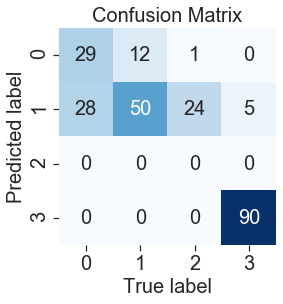

In [264]:
predictions=model1.predict(X_test)
accuracy_ = show_summary_report(y_test, predictions)

# Generating the Base First Level Models
The first level classification models can all be conveniently invoked via the Scikit-Learn library and are listed as follows:

Random Forest classifier

Extra Trees classifier

AdaBoost classifier

Gradient Boosting classifier

Support Vector classifier

# Parameters
A quick summary of the parameters:

n_jobs: Number of cores used for the training process. If set to -1, all cores are used.
n_estimators: Number of classification trees in your learning model (set to 10 per default).
max_depth: Maximum depth of tree, or how much a node should be expanded. Beware if set to too high a number would run the risk of overfitting as one would be growing the tree too deep.
verbose: Controls whether to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.
Please check out the full description via the official Scikit-Learn website.

In [101]:
# Set the parameters for the classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
#     'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

# Extra Trees parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
#     'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
#     'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

In the code below, a class `SklearnHelper` allows to extend the inbuilt methods (such as train, predict and fit) common to all the `Scikit-Learn` classifiers. This cuts out redundancy as it avoids to write the same methods many times when invoking many different classifiers.

In [102]:
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits = NFOLDS, random_state = SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed = 0, params = None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, X_train, y_train):
        self.clf.fit(X_train, y_train)

    def predict(self, X_test):
        return self.clf.predict(X_test)
    
    def fit(self, X_train, y_train):
        return self.clf.fit(X_train, y_train)
    
    def feature_importances(self, X_train, y_train):
        return self.clf.fit(X_train, y_train).feature_importances_

In [103]:
rf  = SklearnHelper(clf = RandomForestClassifier,     seed = SEED, params = rf_params)
et  = SklearnHelper(clf = ExtraTreesClassifier,       seed = SEED, params = et_params)
ada = SklearnHelper(clf = AdaBoostClassifier,         seed = SEED, params = ada_params)
gb  = SklearnHelper(clf = GradientBoostingClassifier, seed = SEED, params = gb_params)
svc = SklearnHelper(clf = SVC,                        seed = SEED, params = svc_params)

# Out-of-Fold Predictions
Stacking uses predictions of base classifiers as input for training to a second level model.

However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second level training.

This runs the risk of the base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.

In [104]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain, ))
    #print(oof_train)
    oof_test = np.zeros((ntest, ))
    #print(oof_train)
    oof_test_skf = np.empty((NFOLDS, ntest))
    #print(oof_test_skf)
    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        #global test_train_index
        #test_train_index=train_index
        #print(train_index)
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis = 0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [105]:
# Create the objects that represent our the models
rf  = SklearnHelper(clf = RandomForestClassifier,     seed = SEED, params = rf_params)
et  = SklearnHelper(clf = ExtraTreesClassifier,       seed = SEED, params = et_params)
ada = SklearnHelper(clf = AdaBoostClassifier,         seed = SEED, params = ada_params)
gb  = SklearnHelper(clf = GradientBoostingClassifier, seed = SEED, params = gb_params)
svc = SklearnHelper(clf = SVC,                        seed = SEED, params = svc_params)

In [106]:
y_train_array = y_train.values
x_train_array = X_train.values
x_test_array = X_test.values

In [107]:
# Create our OOF (Out-of-Fold) train and test predictions
# These base results will be used as new features
et_oof_train,  et_oof_test  = get_oof(et,  x_train_array, y_train_array, x_test_array) # Extra Trees
rf_oof_train,  rf_oof_test  = get_oof(rf,  x_train_array, y_train_array, x_test_array) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train_array, y_train_array, x_test_array) # AdaBoost 
gb_oof_train,  gb_oof_test  = get_oof(gb,  x_train_array, y_train_array, x_test_array) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, x_train_array, y_train_array, x_test_array) # Support Vector Classifier

print('Training is complete')

Training is complete


# Feature importance from the different classifiers
The importance of the various features in the training and test sets is available from the first level classifiers with one very simple line of code.

As per the Scikit-Learn documentation, most of the classifiers are built in with an attribute which returns feature importances by refering to the .featureimportances_ attribute.

NOTE: SVC does not have the .featureimportances_ attribute.

In [108]:
# Create a dataframe with features
cols = X_train.columns.values
feature_dataframe = pd.DataFrame({
    'Feature':        cols,
    'Random Forest':  rf.feature_importances(x_train_array, y_train_array),
    'Extra Trees':    et.feature_importances(x_train_array, y_train_array),
    'AdaBoost':       ada.feature_importances(x_train_array, y_train_array),
    'Gradient Boost': gb.feature_importances(x_train_array, y_train_array)
})

In [109]:
feature_dataframe

,Feature,Random Forest,Extra Trees,AdaBoost,Gradient Boost
0,CustomerID,0.031871,0.021042,0.086,0.090144
1,Recency,0.087573,0.090972,0.012,0.028358
2,Frequency,0.116982,0.090613,0.042,0.132425
3,Payment,0.071646,0.030821,0.060,0.045408
4,Recency_RANK,0.068993,0.066295,0.026,0.041881
5,PCNT_RANK,0.090153,0.070569,0.020,0.039129
6,Ordered_Recency_Per,0.086473,0.072395,0.030,0.094517
7,Frequency_RANK,0.128136,0.182982,0.048,0.108137
8,Payement_RANK,0.077471,0.070193,0.076,0.053919
9,Total_Rank,0.058504,0.105256,0.132,0.067884


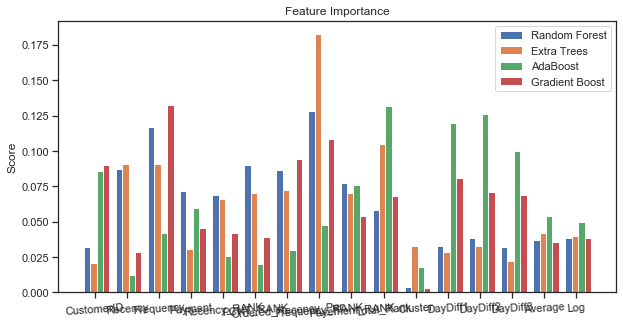

In [110]:
fig = plt.figure(figsize = (10, 5))

ind = np.arange(len(cols)) 
width = 0.2

for i, m in enumerate(feature_dataframe.columns[1:]):
    plt.bar(ind + ((i - 1 - width) * width), feature_dataframe[m], width, label = m)
    
plt.title('Feature Importance')
plt.xticks(ind, cols, rotation = 4)
plt.ylabel('Score')
plt.legend()
plt.show()

In [111]:
# Create a new column containing the average of values
feature_dataframe['Mean'] = feature_dataframe.mean(axis = 1) # axis = 1 computes the mean row-wise
feature_dataframe

,Feature,Random Forest,Extra Trees,AdaBoost,Gradient Boost,Mean
0,CustomerID,0.031871,0.021042,0.086,0.090144,0.057264
1,Recency,0.087573,0.090972,0.012,0.028358,0.054726
2,Frequency,0.116982,0.090613,0.042,0.132425,0.095505
3,Payment,0.071646,0.030821,0.060,0.045408,0.051969
4,Recency_RANK,0.068993,0.066295,0.026,0.041881,0.050792
5,PCNT_RANK,0.090153,0.070569,0.020,0.039129,0.054963
6,Ordered_Recency_Per,0.086473,0.072395,0.030,0.094517,0.070846
7,Frequency_RANK,0.128136,0.182982,0.048,0.108137,0.116814
8,Payement_RANK,0.077471,0.070193,0.076,0.053919,0.069396
9,Total_Rank,0.058504,0.105256,0.132,0.067884,0.090911


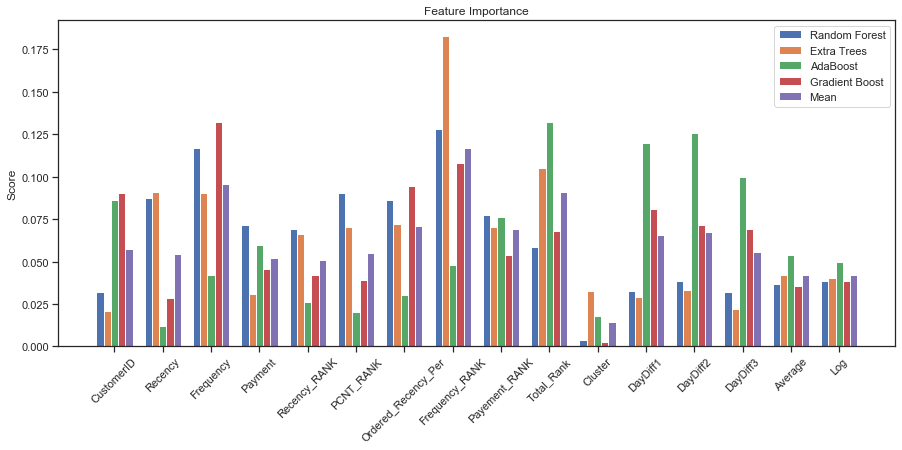

In [112]:
fig = plt.figure(figsize = (15, 6))

ind = np.arange(len(cols)) 
width = 0.15

for i, m in enumerate(feature_dataframe.columns[1:]):
    plt.bar(ind + ((i - 2) * width), feature_dataframe[m], width, label = m)

plt.title('Feature Importance')
plt.xticks(ind, cols, rotation = 45)
plt.ylabel('Score')
plt.legend()
plt.show()

In [141]:
def show_summary_report(actual, prediction):
    if isinstance(actual, pd.Series):
        actual = actual.values.astype(int)
    prediction = prediction.astype(int)
    accuracy_ = accuracy_score(actual, prediction)
    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    mat = confusion_matrix(actual, prediction)
    
    ax = plt.axes()
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', annot_kws={'size':20},ax = ax)
    ax.set_title('Confusion Matrix',fontsize=20)
    ax.set_xlabel('True label',fontsize=20)
    ax.set_ylabel('Predicted label',fontsize=20)
    ax.tick_params(axis='both',labelsize=20)
    ax.set_ylim(sorted(ax.get_xlim(), reverse=True))
    plt.show()
    return (accuracy_)

*****************
* Random Forest *
*****************
Accuracy : 0.7198 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


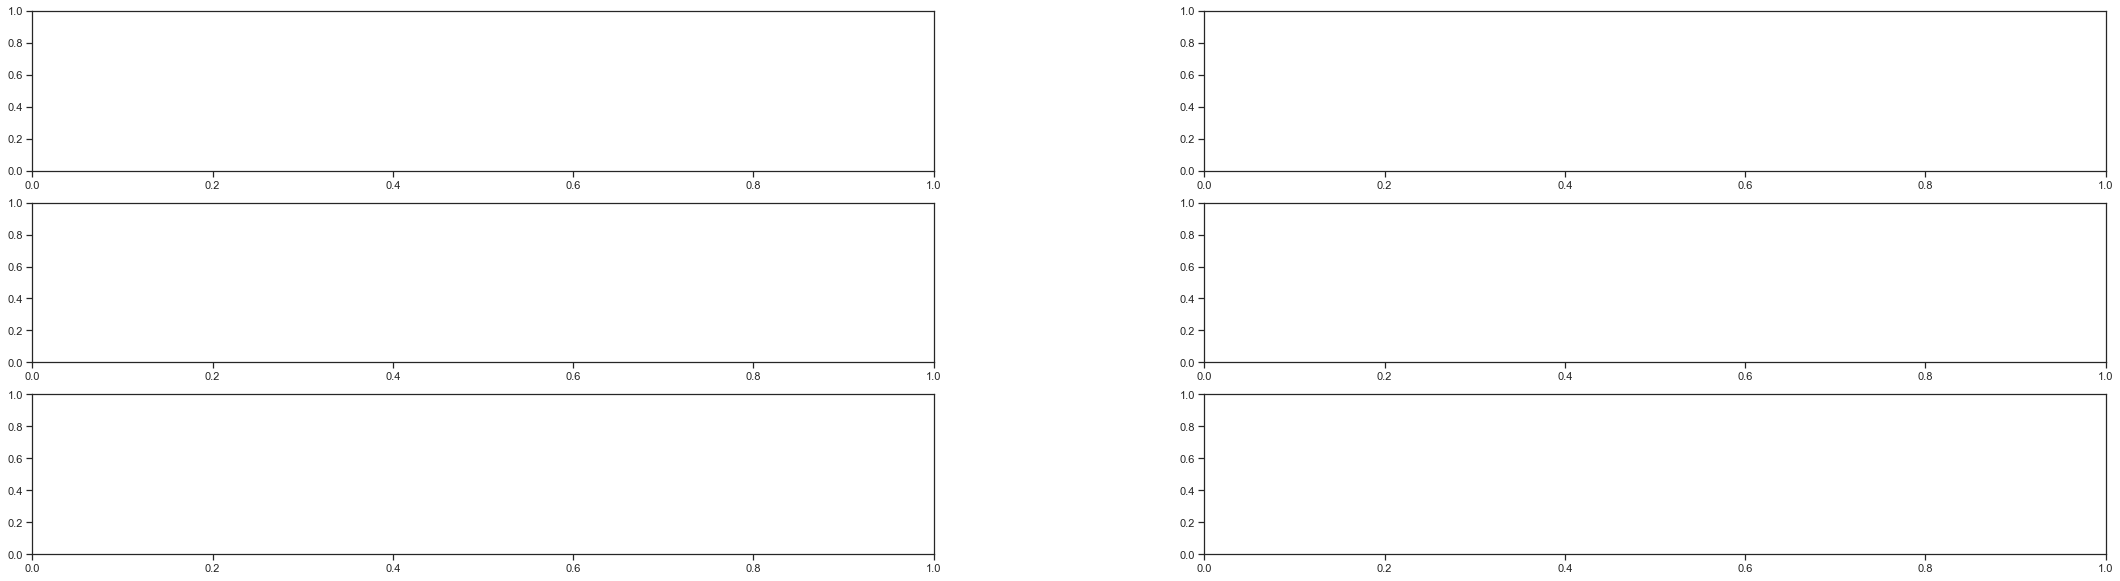

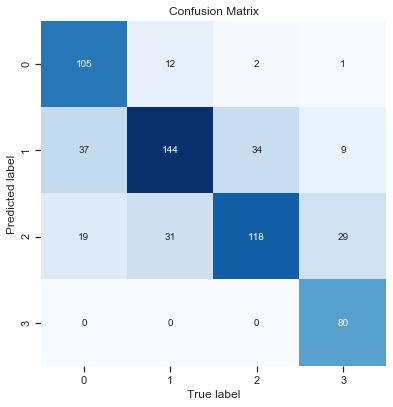


***************
* Extra Trees *
***************
Accuracy : 0.7987 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


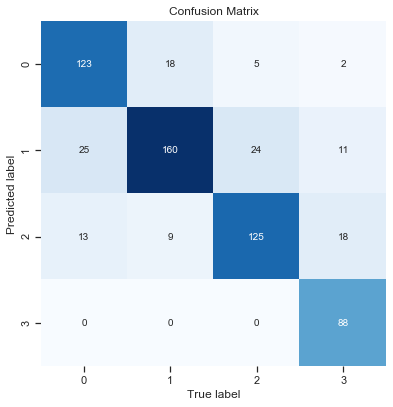


************
* AdaBoost *
************
Accuracy : 0.6377 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


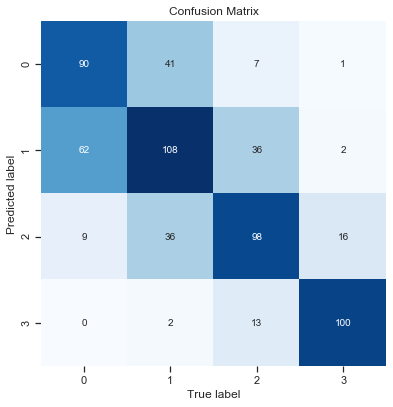


******************
* Gradient Boost *
******************
Accuracy : 1.0000 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


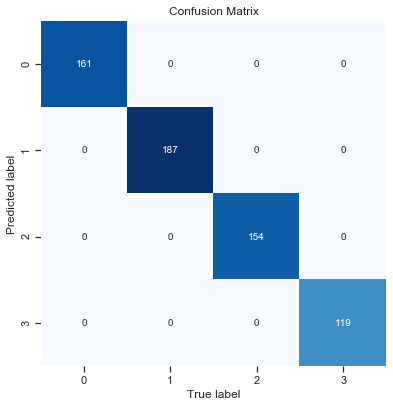


*****************************
* Support Vector Classifier *
*****************************
Accuracy : 0.5765 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


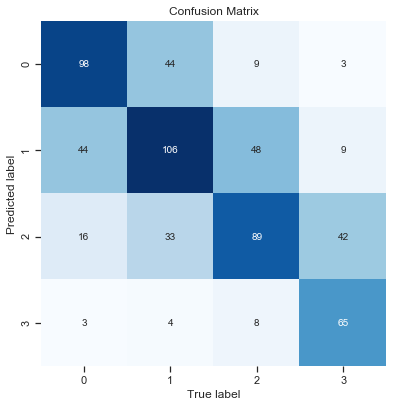

In [114]:
# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Model', 'Accuracy'])
fig, ax = plt.subplots(3, 2, figsize = (30,10))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.3)

models = ['Random Forest', 'Extra Trees', 'AdaBoost', 'Gradient Boost', 'Support Vector Classifier']
for i, m in enumerate([rf, et, ada, gb, svc]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    predictions = m.predict(x_train_array)
    fig, ax = plt.subplots(3, 2, figsize = (5,10))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.3)
    # show the report
    accuracy_= show_summary_report(y_train_array, predictions)
    results.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_}
    print()

# Second Level Predictions from the First Level Output
First level output as new features
One can think of building a new set of features from the first level predictions to be used as training data for the next classifier.

The code below have the first level predictions from the earlier classifiers as new columns and trains the next classifier from those.

In [115]:
base_predictions_train = pd.DataFrame({
    'RandomForest': rf_oof_train.ravel(),
    'ExtraTrees': et_oof_train.ravel(),
    'AdaBoost': ada_oof_train.ravel(),
    'GradientBoost': gb_oof_train.ravel()
})
print('Rows: %d, Columns: %d' % base_predictions_train.shape)
base_predictions_train.head()

Rows: 621, Columns: 4


,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,2.0,2.0,2.0,1.0
1,2.0,2.0,2.0,2.0
2,0.0,0.0,2.0,0.0
3,0.0,0.0,1.0,0.0
4,2.0,2.0,2.0,2.0


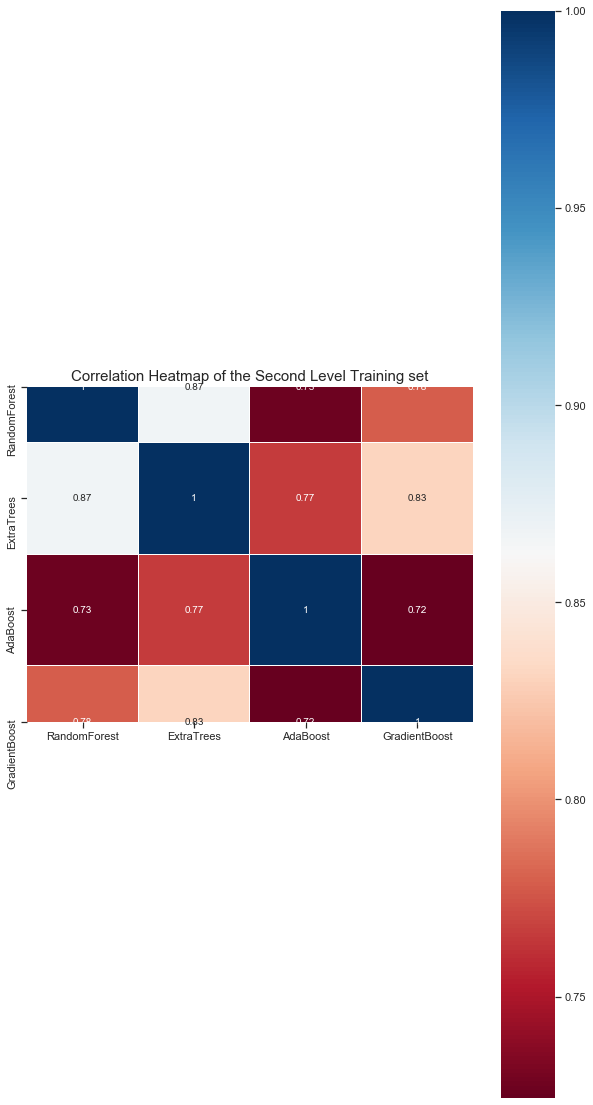

In [116]:
colormap = plt.cm.RdBu
plt.figure(figsize = (10, 20))
plt.title('Correlation Heatmap of the Second Level Training set', size = 15)
sns.heatmap(base_predictions_train.astype(float).corr(),
            linewidths = 0.1,
            vmax = 1.0,
            square = True,
            cmap = colormap,
            linecolor = 'white',
            annot = True)
plt.show()

In [117]:
# Creates a new set of training and test data from the previous results results
xx_train = np.concatenate(
    (et_oof_train,
     rf_oof_train,
     ada_oof_train,
     gb_oof_train,
     svc_oof_train),
    axis = 1)
xx_test = np.concatenate(
    (et_oof_test,
     rf_oof_test,
     ada_oof_test,
     gb_oof_test,
     svc_oof_test),
    axis = 1)

# Second Level learning model via XGBoost
The XGBoost was built to optimize large-scale boosted tree algorithms.

The XGBoost parameters used in the model:

max_depth: How deep to grow the tree. Runs the risk of overfitting if set to too high.
gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.
eta: Step size shrinkage used in each boosting step to prevent overfitting.

In [118]:
gbm = xgb.XGBClassifier(
#     learning_rate = 0.02,
    n_estimators = 2000,
    max_depth = 4,
    min_child_weight = 2,
#     gamma = 1,
    gamma = 0.9,                        
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    nthread = -1,
    scale_pos_weight = 1)

In [119]:
gbm.fit(xx_train, y_train)
predictions = gbm.predict(xx_train)

Accuracy : 0.7536 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


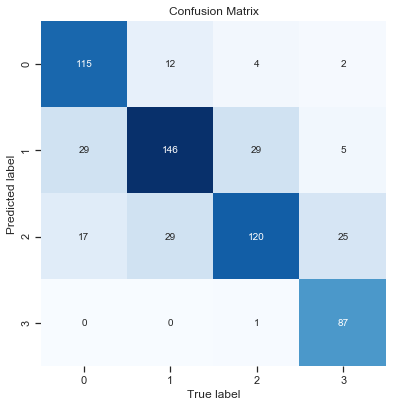

In [120]:
fig, ax = plt.subplots(3, 2, figsize = (5,10))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.3)
accuracy_ = show_summary_report(y_train, predictions)
# keep the results

results.loc[len(results)] = {
    'Model': 'XGBoost', 
    'Accuracy': accuracy_}
print()

In [121]:
results

,Model,Accuracy
0,Random Forest,0.719807
1,Extra Trees,0.798712
2,AdaBoost,0.637681
3,Gradient Boost,1.000000
4,Support Vector Classifier,0.576490
5,XGBoost,0.753623


*****************
* Random Forest *
*****************
Accuracy : 0.5449 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


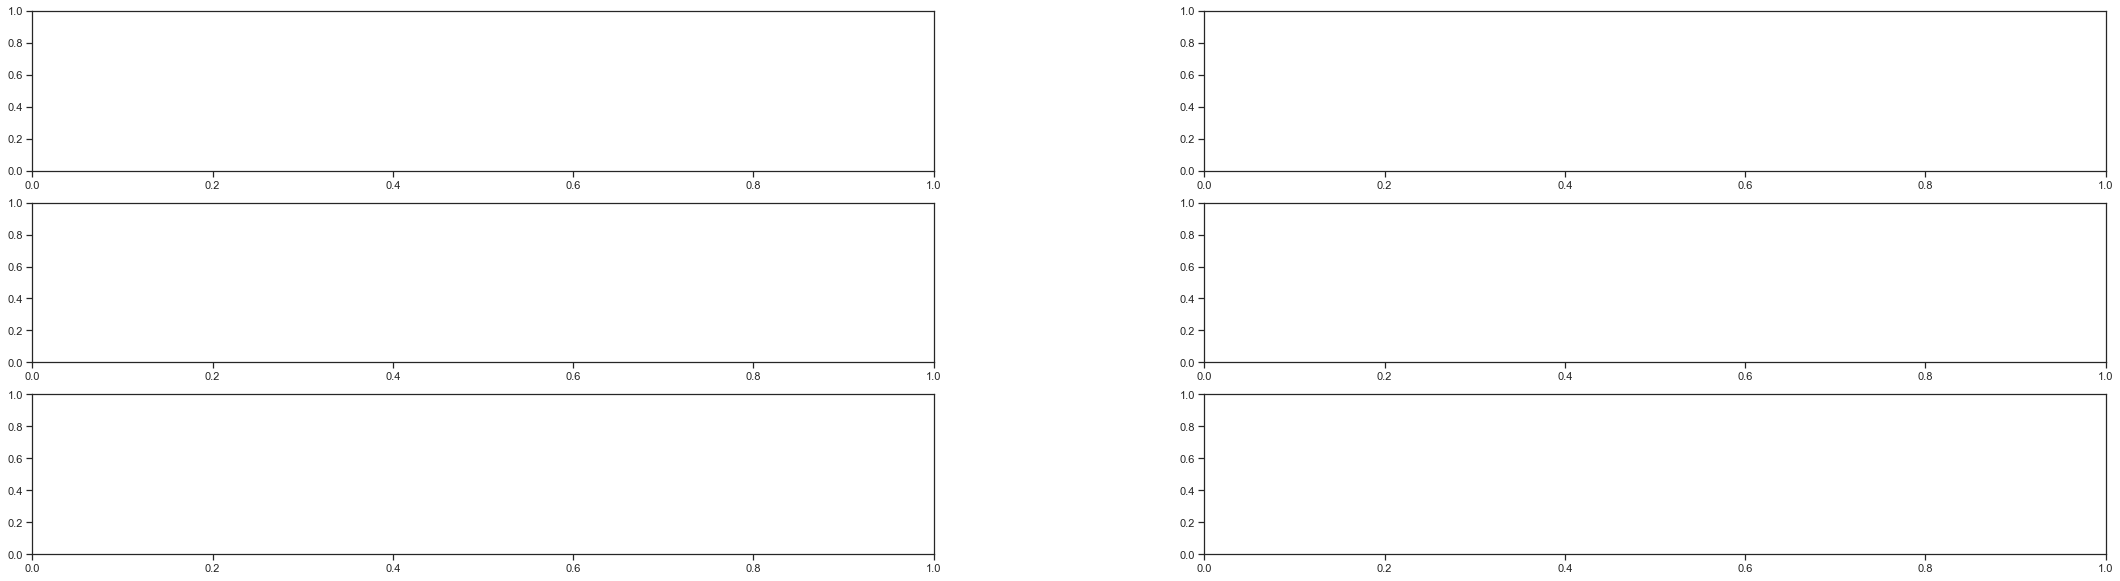

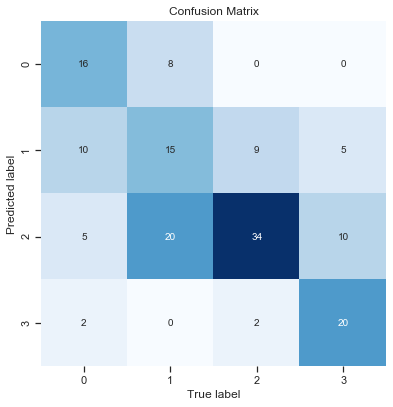


***************
* Extra Trees *
***************
Accuracy : 0.5577 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


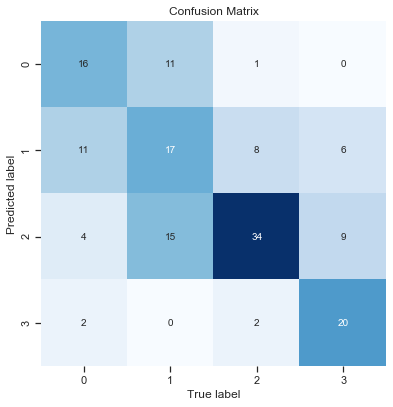


************
* AdaBoost *
************
Accuracy : 0.4615 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


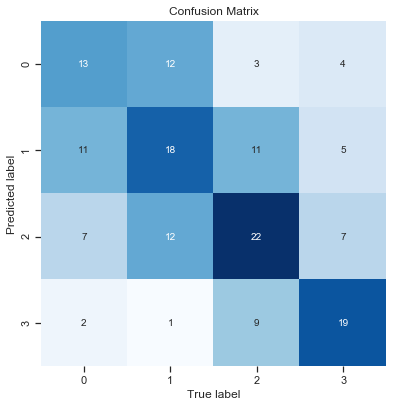


******************
* Gradient Boost *
******************
Accuracy : 0.4936 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


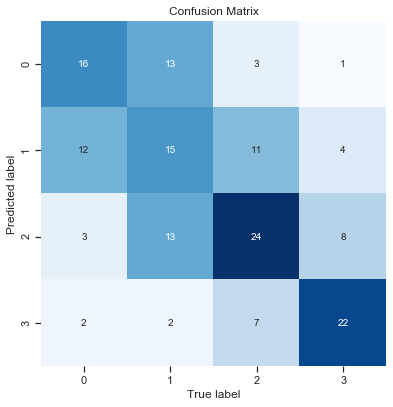


*****************************
* Support Vector Classifier *
*****************************
Accuracy : 0.5321 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


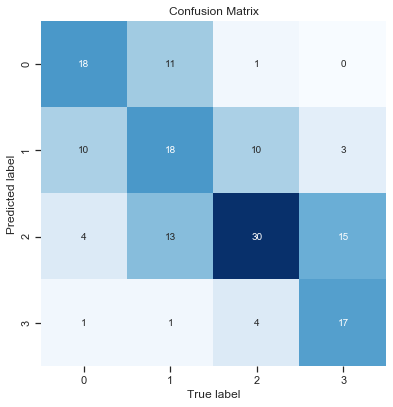

In [122]:
# Keep the results in a dataframe
results_Test = pd.DataFrame(columns = ['Model', 'Accuracy'])
fig, ax = plt.subplots(3, 2, figsize = (30,10))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.3)

models = ['Random Forest', 'Extra Trees', 'AdaBoost', 'Gradient Boost', 'Support Vector Classifier']
for i, m in enumerate([rf, et, ada, gb, svc]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))
    predictions = m.predict(x_test_array)
    fig, ax = plt.subplots(3, 2, figsize = (5,10))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.3)
    # show the report
    accuracy_= show_summary_report(y_test, predictions)
    results_Test.loc[i] = {'Model': models[i], 
                      'Accuracy': accuracy_}
    print()

In [123]:
predictions = gbm.predict(xx_test)

Accuracy : 0.5577 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0


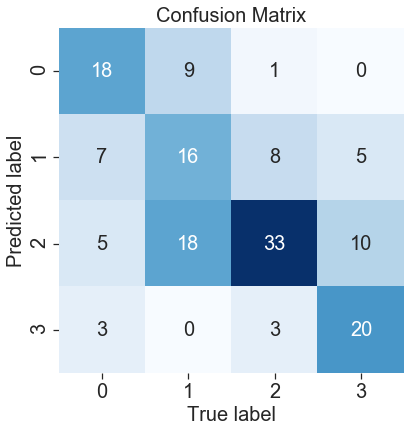

In [142]:
fig, ax = plt.subplots(3, 2, figsize = (5,10))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.3)
accuracy_ = show_summary_report(y_test, predictions)
results_Test.loc[len(results_Test)]={
    'Model': 'XGBoost', 
    'Accuracy': accuracy_}

In [125]:
results_Test

,Model,Accuracy
0,Random Forest,0.544872
1,Extra Trees,0.557692
2,AdaBoost,0.461538
3,Gradient Boost,0.493590
4,Support Vector Classifier,0.532051
5,XGBoost,0.557692


In [1]:
data

NameError: name 'data' is not defined

In [127]:
data1=pd.merge(data, Final_clusters[['CustomerID','Cluster']],on='CustomerID',how='left')

In [128]:
data1

,CustomerID,InvoiceDate,Recency,Frequency,Payment,Recency_RANK,PCNT_RANK,Ordered_Recency_Per,Frequency_RANK,Payement_RANK,...,Cluster_x,InvoiceDay,DayDiff1,DayDiff2,DayDiff3,NextPurchaseDay_TestPeriod,NextPurchaseDayRange,Average,Log,Cluster_y
0,12888.0,2011-05-09 16:02:00,214,2,313.77,3322.0,0.847233,0.152767,0.534813,0.282071,...,0,2011-05-09,6.0,32.0,3.0,999.0,3,13.666667,2.614960,0
1,13420.0,2011-07-13 08:48:00,149,2,140.35,2976.0,0.758990,0.241010,0.534813,0.092833,...,0,2011-07-28,15.0,7.0,14.0,999.0,3,12.000000,2.484907,0
2,15107.0,2011-02-01 14:46:00,311,6,247.66,3735.0,0.952563,0.047437,0.838562,0.212956,...,0,2011-02-01,19.0,2.0,2.0,999.0,3,7.666667,2.036882,0
3,15646.0,2011-07-05 09:53:00,157,3,425.14,3024.0,0.771232,0.228768,0.653405,0.383831,...,0,2011-07-05,85.0,4.0,126.0,999.0,3,71.666667,4.272026,0
4,15648.0,2011-05-19 15:53:00,204,2,599.90,3275.0,0.835246,0.164754,0.534813,0.478449,...,0,2011-05-19,44.0,6.0,13.0,999.0,3,21.000000,3.044522,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,16566.0,2011-11-24 16:34:00,15,5,614.01,882.0,0.224943,0.775057,0.798266,0.488906,...,1,2011-06-22,20.0,2.0,100.0,113.0,2,40.666667,3.705409,1
773,16668.0,2011-11-24 17:43:00,15,6,306.72,882.0,0.224943,0.775057,0.838562,0.270849,...,1,2011-07-24,44.0,32.0,70.0,21.0,0,48.666667,3.884994,1
774,17115.0,2011-12-01 14:30:00,8,3,806.90,560.0,0.142821,0.857179,0.653405,0.578934,...,1,2011-06-13,3.0,44.0,7.0,999.0,3,18.000000,2.890372,1
775,17526.0,2011-12-05 11:05:00,4,4,706.70,378.0,0.096404,0.903596,0.742923,0.540933,...,1,2011-05-19,49.0,37.0,70.0,999.0,3,52.000000,3.951244,1


In [129]:
data1['Cluster_y'].value_counts()

3    548
2    202
0     21
1      6
Name: Cluster_y, dtype: int64

In [130]:
plot_frequency1=data1
plot_frequency1=data1[data1['Cluster_y']>1]

In [131]:
plot_frequency1

,CustomerID,InvoiceDate,Recency,Frequency,Payment,Recency_RANK,PCNT_RANK,Ordered_Recency_Per,Frequency_RANK,Payement_RANK,...,Cluster_x,InvoiceDay,DayDiff1,DayDiff2,DayDiff3,NextPurchaseDay_TestPeriod,NextPurchaseDayRange,Average,Log,Cluster_y
21,12747.0,2011-12-07 14:34:00,2,11,4196.01,208.0,0.053048,0.946952,0.933435,0.930630,...,3,2011-06-28,34.0,20.0,65.0,55.0,1,39.666667,3.680511,3
22,12748.0,2011-12-09 12:20:00,0,210,29072.10,28.0,0.007141,0.992859,1.000000,0.994644,...,3,2011-07-31,2.0,1.0,7.0,2.0,0,3.333333,1.203973,3
23,12826.0,2011-12-07 10:25:00,2,7,1468.12,208.0,0.053048,0.946952,0.871716,0.738842,...,3,2011-06-24,10.0,138.0,8.0,107.0,2,52.000000,3.951244,3
24,12830.0,2011-11-02 11:54:00,37,6,6748.40,1702.0,0.434073,0.565927,0.838562,0.965570,...,3,2011-07-28,7.0,15.0,15.0,42.0,1,12.333333,2.512306,3
25,12839.0,2011-12-07 12:33:00,2,14,5583.62,208.0,0.053048,0.946952,0.956134,0.952818,...,3,2011-07-29,24.0,26.0,15.0,19.0,0,21.666667,3.075775,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,18231.0,2011-05-31 14:18:00,192,5,2066.17,3217.0,0.820454,0.179546,0.798266,0.817138,...,2,2011-05-31,43.0,5.0,28.0,999.0,3,25.333333,3.232121,2
767,18232.0,2011-09-19 11:49:00,81,4,582.47,2529.0,0.644989,0.355011,0.742923,0.467738,...,2,2011-07-05,32.0,3.0,5.0,76.0,2,13.333333,2.590267,2
768,18239.0,2011-05-05 12:38:00,218,5,1561.61,3353.0,0.855139,0.144861,0.798266,0.755164,...,2,2011-05-05,42.0,52.0,10.0,999.0,3,34.666667,3.545779,2
769,18257.0,2011-10-31 14:48:00,39,8,2265.38,1744.0,0.444784,0.555216,0.893905,0.837031,...,2,2011-06-24,23.0,9.0,6.0,54.0,1,12.666667,2.538974,2


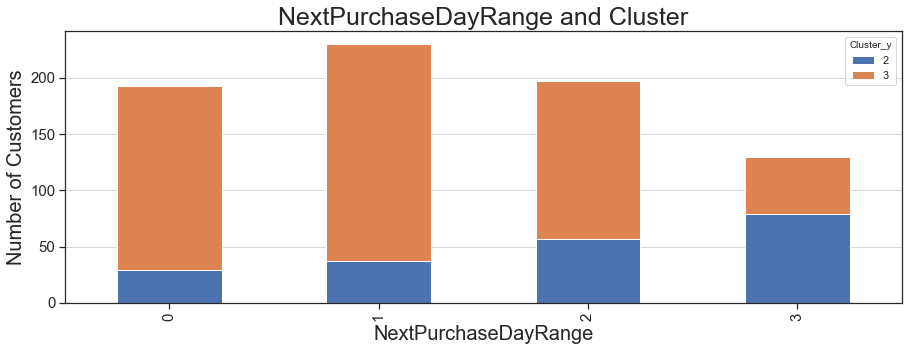

In [132]:
plot_frequency1.groupby(['NextPurchaseDayRange', 'Cluster_y']).size().unstack().plot(kind='bar', stacked=True, figsize=(15, 5))
plt.title('NextPurchaseDayRange and Cluster',fontsize=25)
plt.xlabel('NextPurchaseDayRange',fontsize=20)
plt.ylabel('Number of Customers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', alpha=0.75)

# Extra code to get the sales increase

In [144]:
#Considering value from cluster 2 for value dectection

value=data1[data1['Cluster_y']==2]

In [145]:
value

,CustomerID,InvoiceDate,Recency,Frequency,Payment,Recency_RANK,PCNT_RANK,Ordered_Recency_Per,Frequency_RANK,Payement_RANK,...,Cluster_x,InvoiceDay,DayDiff1,DayDiff2,DayDiff3,NextPurchaseDay_TestPeriod,NextPurchaseDayRange,Average,Log,Cluster_y
569,12840.0,2011-07-19 09:29:00,143,4,2714.27,2948.0,0.751849,0.248151,0.742923,0.869931,...,2,2011-07-19,39.0,32.0,4.0,999.0,3,25.000000,3.218876,2
570,12845.0,2011-03-17 13:34:00,267,4,354.09,3574.0,0.911502,0.088498,0.742923,0.325682,...,2,2011-03-17,1.0,2.0,20.0,999.0,3,7.666667,2.036882,2
571,12853.0,2011-07-28 11:29:00,134,6,1881.70,2905.0,0.740882,0.259118,0.838562,0.797756,...,2,2011-07-28,80.0,25.0,73.0,999.0,3,59.333333,4.083171,2
572,12868.0,2011-06-07 10:42:00,185,6,1607.06,3179.0,0.810763,0.189237,0.838562,0.759245,...,2,2011-06-07,33.0,50.0,48.0,999.0,3,43.666667,3.776585,2
573,12916.0,2011-07-24 10:35:00,138,4,2982.35,2929.0,0.747003,0.252997,0.742923,0.884723,...,2,2011-07-24,63.0,56.0,63.0,999.0,3,60.666667,4.105394,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,18231.0,2011-05-31 14:18:00,192,5,2066.17,3217.0,0.820454,0.179546,0.798266,0.817138,...,2,2011-05-31,43.0,5.0,28.0,999.0,3,25.333333,3.232121,2
767,18232.0,2011-09-19 11:49:00,81,4,582.47,2529.0,0.644989,0.355011,0.742923,0.467738,...,2,2011-07-05,32.0,3.0,5.0,76.0,2,13.333333,2.590267,2
768,18239.0,2011-05-05 12:38:00,218,5,1561.61,3353.0,0.855139,0.144861,0.798266,0.755164,...,2,2011-05-05,42.0,52.0,10.0,999.0,3,34.666667,3.545779,2
769,18257.0,2011-10-31 14:48:00,39,8,2265.38,1744.0,0.444784,0.555216,0.893905,0.837031,...,2,2011-06-24,23.0,9.0,6.0,54.0,1,12.666667,2.538974,2


In [157]:
value['Payment'].min()

354.09000000000003

In [163]:
value['Payment'].mean()

1861.6860891089111

In [164]:
value1['Payment'].mean()

7116.096113138691

In [158]:
value1=data1[data1['Cluster_y']==3]
value1['Payment'].min()

488.03000000000003

In [151]:
value1

,CustomerID,InvoiceDate,Recency,Frequency,Payment,Recency_RANK,PCNT_RANK,Ordered_Recency_Per,Frequency_RANK,Payement_RANK,...,Cluster_x,InvoiceDay,DayDiff1,DayDiff2,DayDiff3,NextPurchaseDay_TestPeriod,NextPurchaseDayRange,Average,Log,Cluster_y
21,12747.0,2011-12-07 14:34:00,2,11,4196.01,208.0,0.053048,0.946952,0.933435,0.930630,...,3,2011-06-28,34.0,20.0,65.0,55.0,1,39.666667,3.680511,3
22,12748.0,2011-12-09 12:20:00,0,210,29072.10,28.0,0.007141,0.992859,1.000000,0.994644,...,3,2011-07-31,2.0,1.0,7.0,2.0,0,3.333333,1.203973,3
23,12826.0,2011-12-07 10:25:00,2,7,1468.12,208.0,0.053048,0.946952,0.871716,0.738842,...,3,2011-06-24,10.0,138.0,8.0,107.0,2,52.000000,3.951244,3
24,12830.0,2011-11-02 11:54:00,37,6,6748.40,1702.0,0.434073,0.565927,0.838562,0.965570,...,3,2011-07-28,7.0,15.0,15.0,42.0,1,12.333333,2.512306,3
25,12839.0,2011-12-07 12:33:00,2,14,5583.62,208.0,0.053048,0.946952,0.956134,0.952818,...,3,2011-07-29,24.0,26.0,15.0,19.0,0,21.666667,3.075775,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,18230.0,2011-11-30 13:22:00,9,7,2716.60,621.0,0.158378,0.841622,0.871716,0.870186,...,3,2011-06-19,34.0,45.0,50.0,79.0,2,43.000000,3.761200,3
565,18241.0,2011-11-30 12:10:00,9,17,2058.09,621.0,0.158378,0.841622,0.969141,0.816118,...,3,2011-07-27,29.0,12.0,41.0,7.0,0,27.333333,3.308107,3
566,18245.0,2011-12-02 14:48:00,7,7,2507.56,485.0,0.123693,0.876307,0.871716,0.854884,...,3,2011-07-13,62.0,94.0,7.0,999.0,3,54.333333,3.995138,3
567,18272.0,2011-12-07 12:43:00,2,6,3064.78,208.0,0.053048,0.946952,0.838562,0.888294,...,3,2011-07-12,62.0,13.0,21.0,36.0,1,32.000000,3.465736,3


In [162]:
(value1['Payment'].mean()-value['Payment'].mean())*value['Payment'].count()

1061390.8248540156

In [161]:
(value1['Payment'].min()-value['Payment'].min())*value['Payment'].count()

27055.88

In [165]:
filter1=data1['Cluster_y']==3
filter2=data1['NextPurchaseDayRange']==1
Value3=data1[filter1 & filter2]

In [168]:
filter1=data1['Cluster_y']==3
filter2=data1['NextPurchaseDayRange']==0
Value4=data1[filter1 & filter2]

In [167]:
Value3['Payment'].sum()

1067890.0399999998

In [169]:
Value4['Payment'].sum()

2237335.5500000007

In [171]:
#Sales increase in percentage
((Value4['Payment'].sum()-Value3['Payment'].sum())*100)/Value4['Payment'].sum()

52.26956278417873

In [172]:
customer_ds

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,payment_value
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,15.30
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
2,536365,8,2010-12-01 08:26:00,2.75,17850.0,22.00
3,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
4,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
...,...,...,...,...,...,...
541889,581585,12,2011-12-09 12:31:00,1.95,15804.0,23.40
541890,581586,8,2011-12-09 12:49:00,2.95,13113.0,23.60
541891,581586,24,2011-12-09 12:49:00,1.25,13113.0,30.00
541892,581586,24,2011-12-09 12:49:00,8.95,13113.0,214.80


In [193]:
revenue=customer_ds[customer_ds['InvoiceDate']>end_date]

In [194]:
revenue

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,payment_value
431673,573744,8,2011-11-01 08:16:00,2.10,17733.0,16.8
431674,573744,12,2011-11-01 08:16:00,0.85,17733.0,10.2
431675,573744,12,2011-11-01 08:16:00,1.25,17733.0,15.0
431676,573744,12,2011-11-01 08:16:00,1.25,17733.0,15.0
431677,573744,12,2011-11-01 08:16:00,1.25,17733.0,15.0
...,...,...,...,...,...,...
541889,581585,12,2011-12-09 12:31:00,1.95,15804.0,23.4
541890,581586,8,2011-12-09 12:49:00,2.95,13113.0,23.6
541891,581586,24,2011-12-09 12:49:00,1.25,13113.0,30.0
541892,581586,24,2011-12-09 12:49:00,8.95,13113.0,214.8


In [195]:
revenue2=pd.merge(revenue, data[['CustomerID','Cluster','NextPurchaseDayRange']],on='CustomerID',how='right')

In [196]:
revenue2

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,payment_value,Cluster,NextPurchaseDayRange
0,573745,12.0,2011-11-01 08:53:00,2.08,17419.0,24.96,3,2
1,573745,12.0,2011-11-01 08:53:00,1.65,17419.0,19.80,3,2
2,573745,6.0,2011-11-01 08:53:00,3.25,17419.0,19.50,3,2
3,573745,12.0,2011-11-01 08:53:00,1.25,17419.0,15.00,3,2
4,573745,12.0,2011-11-01 08:53:00,1.25,17419.0,15.00,3,2
...,...,...,...,...,...,...,...,...
29200,NaN,NaN,NaT,NaN,18231.0,NaN,2,3
29201,NaN,NaN,NaT,NaN,18232.0,NaN,2,2
29202,NaN,NaN,NaT,NaN,18239.0,NaN,2,3
29203,NaN,NaN,NaT,NaN,18257.0,NaN,2,1


In [199]:
filter1=revenue2['Cluster']==3
filter2=revenue2['NextPurchaseDayRange']==1
Value5=revenue2[filter1 & filter2]

filter1=revenue2['Cluster']==3
filter2=revenue2['NextPurchaseDayRange']==0
Value6=revenue2[filter1 & filter2]

In [204]:
Value5['payment_value'].sum()

170042.24000000002

In [205]:
Value6['payment_value'].sum()

366214.97

In [207]:
Value5['payment_value'].count()

7449